# Lab 11: Model Predictive Control II

ME C231A, EECS C220B, UC Berkeley

***

In [5]:
# # Run this cell if you are using Colab
# install required dependencies


# import sys
# IN_COLAB = 'google.colab' in sys.modules
# if IN_COLAB:
#   !pip install -q pyomo
#   !apt-get install -y -qq glpk-utils
#   !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
#   !unzip -o -q ipopt-linux64
#   !apt-get install -y -qq coinor-cbc

***

In *this* lab, we introduce:
1. linear MPC design with zero steady-state tracking,
2. MPC design with soft constraints.

***

# <font color=blue> Linear MPC Design with  Zero Steady-State Tracking </font>

The inverted pendulum system is described by the continuous-time dynamics

\begin{equation}
\begin{aligned}
\begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \end{bmatrix} &=
\underbrace{\begin{bmatrix} 0 & 1 \\ 2.5 & -0.05  \end{bmatrix}}_{A_c}\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} +
\underbrace{\begin{bmatrix}0 \\ 2.5 \end{bmatrix}}_{B_c} u.\\
y&=\begin{bmatrix} 1 & 0 \end{bmatrix}\begin{bmatrix} x_1 \\ x_2 \end{bmatrix}    \
\end{aligned}
\end{equation}

Convert the system to discrete-time using the $\texttt{scipy}$ command $\texttt{scipy.signal.cont2discrete}$ before proceeding. Use the sampling time of $T_s = 0.1$. In this lab will assume the inverted pendulum system has the following state constraints
\begin{equation}
\begin{aligned}
-\pi/2 \leq &x_1 \leq \pi/2 \\
-\pi \leq &x_2 \leq \pi
\end{aligned}
\end{equation}
and input constraint

\begin{align}
-1.75 \leq u \leq 1.75
\end{align}
where $x_1$ is the angle of the pendulum, $x_2$ is the angular velocity of the pendulum, and $u$ is the speed of the cart.  

The ultimate goal is to design a 2-norm MPC with  $Q=eye(2)$, $R=1$ and $N=6$, $P=Q$, ${X}_f=\mathbb{R}^2$ (no terminal constraint) which guarantees zero tracking error in the presence of model mismatch.

We will use the output reference
\begin{equation}
r(k)=\left\{\begin{array} $0 \quad \text{if} \quad k \leq 40\\1 \quad \text{if} \quad k\geq40 \end{array}\right. 
\end{equation}
and proceed step by step.

In [6]:
import numpy as np
import scipy.signal
import scipy.linalg
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


Ts = 0.1       # Ts is the discrete sample-time. 

Ac = np.array([[0, 1],
               [2.5, -0.05]])
Bc = np.array([[0],
               [2.5]])

Cc = np.array([1, 0])
# We don't need D here. This is just for calling the function
Dc = np.zeros((1,1))
system = (Ac, Bc, Cc, Dc)
A, B, C, D, dt = scipy.signal.cont2discrete(system, Ts)

Q = np.diag([100,1])
R = np.array([1]).reshape(1,1)
P = Q
N = 6

uU = 1.75
uL = -1.75
x1U = np.pi/2
x2U = np.pi

C = C.reshape(1,2)


***

# <font color=blue> Case 1: full preview is available:  </font> 

Assume the full state is available and design a tracking MPC with the objective function as
\begin{equation}
(x_N-\bar{x}_N)'P (x_N-\bar{x}_N)+ \sum_{k=0}^{N-1} (x_k-\bar{x}_k)'Q(x_k-\bar{x}_k) + (u_{k}-\bar{u}_k)'R(u_{k}-\bar{u}_k)
\end{equation}

where $\bar{x}_k$ and $\bar{u}_k$ are the reference state and inputs computed to follow the given reference.

Note that $\bar{x}_k$ and $\bar{u}_k$ change over the prediction horizon since we assume to have full information of the reference.
Close the loop assuming there is no model mismatch, start with $x(0)=[-0.5,1]^T$.

Plot the open loop and closed loop trajectories of $x$ and $y$ versus time.

In [7]:
from __future__ import division
import pyomo.environ as pyo
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


# Setup optimization problem
def solve_cftoc(A, B, P, Q, R, N, x0, x1U, x2U, uL, uU, xref, uref):
    
    model = pyo.ConcreteModel()
    model.N = N
    model.nx = np.size(A, 0)
    model.nu = np.size(B, 1)

    
    # length of finite optimization problem:
    model.tIDX = pyo.Set( initialize= range(model.N+1), ordered=True )
    model.xIDX = pyo.Set( initialize= range(model.nx), ordered=True )
    model.uIDX = pyo.Set( initialize= range(model.nu), ordered=True )
    
    
    # these are 2d arrays:
    model.A = A
    model.B = B
    model.Q = Q
    model.P = P
    model.R = R
    
    # difference is the ref here
    model.xref = xref
    model.uref = uref  
    
    # Create state and input variables trajectory:
    model.x = pyo.Var(model.xIDX, model.tIDX)
    model.u = pyo.Var(model.uIDX, model.tIDX, bounds=(uL,uU))

    
    #Objective:
    def objective_rule(model):
        costX = 0.0
        costU = 0.0
        costTerminal = 0.0
        for t in model.tIDX:
            for i in model.xIDX:
                for j in model.xIDX:
                    if t < model.N:
                        costX += (model.x[i, t] - model.xref[i, t]) * model.Q[i, j] * (model.x[j, t] - model.xref[j, t]) 
        for t in model.tIDX:
            for i in model.uIDX:
                for j in model.uIDX:
                    if t < model.N:
                        costU += (model.u[i, t] - model.uref[i, t]) * model.R[i, j] * (model.u[j, t] - model.uref[j, t])
        for i in model.xIDX:
            for j in model.xIDX:               
                costTerminal += (model.x[i, model.N] - model.xref[i, model.N]) * model.P[i, j] * (model.x[j, model.N] - model.xref[j, model.N])
        return costX + costU + costTerminal
    
    model.cost = pyo.Objective(rule = objective_rule, sense=pyo.minimize)
    
    # Constraints:
    def equality_const_rule(model, i, t):
        return model.x[i, t+1] - (sum(model.A[i, j] * model.x[j, t] for j in model.xIDX)
                               +  sum(model.B[i, j] * model.u[j, t] for j in model.uIDX) ) == 0.0 if t < model.N else pyo.Constraint.Skip

    model.equality_constraints = pyo.Constraint(model.xIDX, model.tIDX, rule=equality_const_rule)
    model.init_const1 = pyo.Constraint(expr = model.x[0, 0] == x0[0])
    model.init_const2 = pyo.Constraint(expr = model.x[1, 0] == x0[1])
    
    model.state_limit1 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[0, t] <= x1U
                                   if t < N else pyo.Constraint.Skip)
    model.state_limit2 = pyo.Constraint(model.tIDX, rule=lambda model, t: -x1U <= model.x[0, t]
                                    if t < N else pyo.Constraint.Skip)
    model.state_limit3 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[1, t] <= x2U
                                   if t < N else pyo.Constraint.Skip)
    model.state_limit4 = pyo.Constraint(model.tIDX, rule=lambda model, t: -x2U <= model.x[1, t]
                                    if t < N else pyo.Constraint.Skip)
            
    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)
    
    if str(results.solver.termination_condition) == "optimal":
        feas = True
    else:
        feas = False
            
    xOpt = np.asarray([[model.x[i,t]() for i in model.xIDX] for t in model.tIDX]).T
    uOpt = np.asarray([model.u[:,t]() for t in model.tIDX]).T
    
    JOpt = model.cost()
      
    return [model, feas, xOpt, uOpt, JOpt]

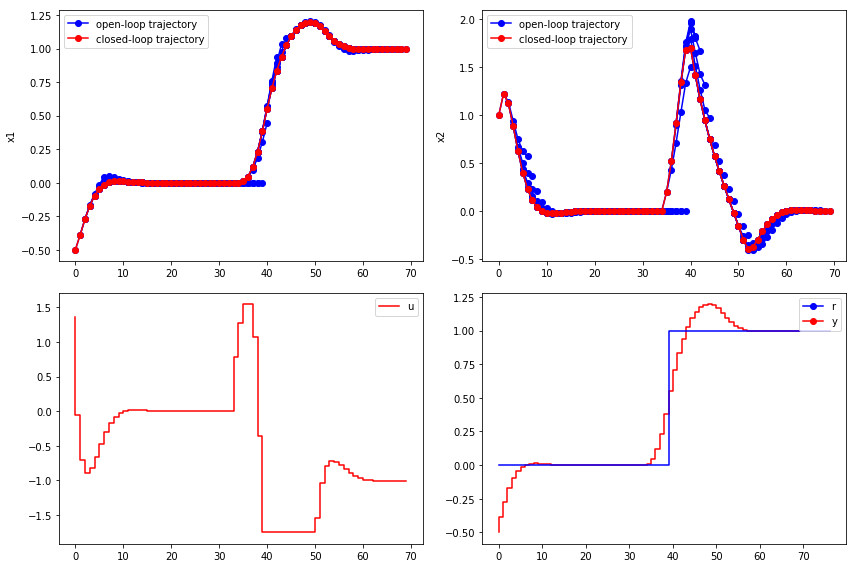

In [8]:
# %matplotlib widget

nx = np.size(A, 0)  # number of states
nu = np.size(B, 1)  # number of inputs
ny = np.size(C, 0)  # number of outputs

x0 = np.array([-0.5, 1.0])
Lsim = 70    # length of simulation
ref = []

# Construct reference signal
for k in range(Lsim+N+1):
    if k < 40: 
        ref.append(0)
    else:
        ref.append(1)

# Initialize  Control Design

umpc_closedloop = []
ym = []
xk_open = np.zeros((nx, N+1))    # to plot open-loop trajectories
xk_closed = np.zeros((nx, Lsim+1)) # to plot closed-loop trajectories
xk_closed[:, 0] = x0      # set initial value of closed-loop trajectory
xk = x0.reshape(2,1)

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
# simulate MPC controller
for t in range(Lsim):

# Target Algorithm   
    # construct reference preview
    ref_preview = [ref[j] for j in range(t, t+N+1)]
#     ref_preview = ref[t:t+N+1]
    # compute xref and uref based on futture reference
    xrefk = np.zeros((nx,N+1))
    urefk = np.zeros((nu,N))
    for k in range(N+1):
        Geq = np.vstack( ( np.hstack( (A-np.eye(nx), B) ), np.hstack( (C , np.zeros((ny,nu))) ) ) )
        beq = np.concatenate([np.zeros((nx,1)), np.asarray(ref_preview[k]).reshape(1,1)], axis = 0)   

        # If Geq invertible
        out = (np.linalg.inv(Geq) @ beq).flatten()
        xrefk[:, k] = out[0:nx]
        if k is not N:
            urefk[:, k] = out[nx:nx+nu]

    # Solve MPC 
    [model, feas, xOpt, uOpt, JOpt] = solve_cftoc(A, B, P, Q, R, N, xk.reshape(2,), x1U, x2U, uL, uU, xrefk, urefk)
    if feas == False:
        print('The problem is infeasible')
    U = uOpt[0,0]
    umpc_closedloop.append(U)
                                    
    if (t < (Lsim-N)):
    # plot open-loop trajectories
        xk_open[:, 0] = xk.reshape(2,)

        for m in range(N):
            xk_open[:, m+1] = A @ xk_open[:, m] + B @ uOpt[:, m]  

        line1 = ax1.plot(range(t, t+len(ref_preview) ), xk_open[0,:], 'o-', color='b')
        line2 = ax2.plot(range(t, t+len(ref_preview) ), xk_open[1,:], 'o-', color='b')

    # Plant model update
    ym.append(C @ xk)
    xk = A @ xk + B @ np.asarray(U).reshape(1,1)
    xk_closed[:, t+1] = xk.reshape(2,)
        
##################################################################################################################
##################################################################################################################
# plot closed-loop trajectories

line11 = ax1.plot(range(Lsim), xk_closed[0, :Lsim], 'o-', color='r')
ax1.legend([line1[0], line11[0]], ['open-loop trajectory', 'closed-loop trajectory'])
ax1.set_ylabel('x1')
line22 = ax2.plot(range(Lsim), xk_closed[1, :Lsim], 'o-', color='r')
ax2.legend([line2[0], line22[0]], ['open-loop trajectory', 'closed-loop trajectory'])
ax2.set_ylabel('x2')
# plt.show()

# Plot Results
ax12 = fig.add_subplot(223)
ax22 = fig.add_subplot(224)
ax12.step(range(len(umpc_closedloop)), umpc_closedloop,'r')
ax12.legend(['u'])
ax22.step(range(len(ym)), np.asarray(ym).reshape(Lsim,), 'r')
ax22.step(range(len(ref)), ref, 'b--')
ax22.legend([line2[0], line22[0]], ['r', 'y'])
plt.tight_layout()
plt.show()

# print('x1=', xrefk[0,:])
# print('x2=', xrefk[1,:])
# print('u=', urefk)

***

# <font color=blue> Case 2: full preview is not available:  </font>
Repeat the same design as in the previous question, replacing the cost with
\begin{equation}
(x_N-\bar{x})'P (x_N-\bar{x})+ \sum_{k=0}^{N-1} (x_k-\bar{x})'Q(x_k-\bar{x}) + (u_{k}-\bar{u})'R(u_{k}-\bar{u})
\end{equation}

where $\bar{x}$ and $\bar{u}$ are the reference state and inputs computed to follow the reference. This time $\bar{x}$ and $\bar{u}$ are constant over the horizon and represent the case when a reference preview is not available.

Close the loop assuming there is no model mismatch, start with $x(0)=[-0.5, 1]^T$.
Plot the open loop and closed loop trajectories of $x$ and $y$ versus time. 

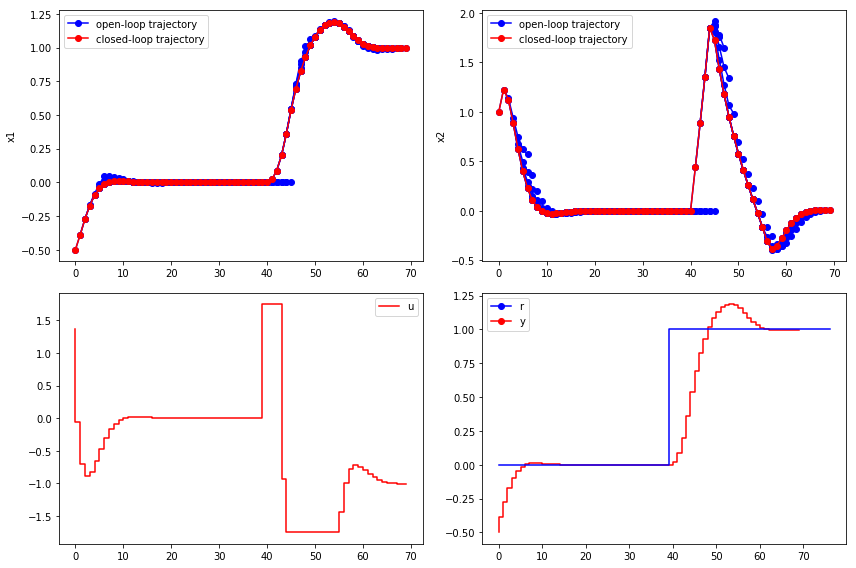

In [9]:
# Write your code here:

nx = np.size(A, 0)  # number of states
nu = np.size(B, 1)  # number of inputs
ny = np.size(C, 0)  # number of outputs

x0 = np.array([-0.5, 1.0])
Lsim = 70    # length of simulation
ref = []

# Construct reference signal
for k in range(Lsim+N+1):
    if k < 40: 
        ref.append(0)
    else:
        ref.append(1)

# Initialize  Control Design

umpc_closedloop = []
ym = []
xk_open = np.zeros((nx, N+1))    # to plot open-loop trajectories
xk_closed = np.zeros((nx, Lsim+1)) # to plot closed-loop trajectories
xk_closed[:, 0] = x0      # set initial value of closed-loop trajectory
xk = x0.reshape(2,1)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

# simulate MPC controller
for t in range(Lsim):

# Target Algorithm   
    # construct reference preview
    # ref_preview = [ref[j] for j in range(t, t+N+1)]
    ref_preview = ref[t]*np.ones((N+1,1))
#     ref_preview = ref[t:t+N+1]
    # compute xref and uref based on futture reference
    xrefk = np.zeros((nx,N+1))
    urefk = np.zeros((nu,N))
    for k in range(N+1):
        Geq = np.vstack( ( np.hstack( (A-np.eye(nx), B) ), np.hstack( (C , np.zeros((ny,nu))) ) ) )
        beq = np.concatenate([np.zeros((nx,1)), np.asarray(ref_preview[k]).reshape(1,1)], axis = 0)   

        # If Geq invertible
        out = (np.linalg.inv(Geq) @ beq).flatten()
        xrefk[:, k] = out[0:nx]
        if k is not N:
            urefk[:, k] = out[nx:nx+nu]

    # Solve MPC 
    [model, feas, xOpt, uOpt, JOpt] = solve_cftoc(A, B, P, Q, R, N, xk.reshape(2,), x1U, x2U, uL, uU, xrefk, urefk)
    if feas == False:
        print('The problem is infeasible')
    U = uOpt[0,0]
    umpc_closedloop.append(U)
                                    
    if (t < (Lsim-N)):
    # plot open-loop trajectories
        xk_open[:, 0] = xk.reshape(2,)

        for m in range(N):
            xk_open[:, m+1] = A @ xk_open[:, m] + B @ uOpt[:, m]  

        line1 = ax1.plot(range(t, t+len(ref_preview) ), xk_open[0,:], 'o-', color='b')
        line2 = ax2.plot(range(t, t+len(ref_preview) ), xk_open[1,:], 'o-', color='b')

    # Plant model update
    ym.append(C @ xk)
    xk = A @ xk + B @ np.asarray(U).reshape(1,1)
    xk_closed[:, t+1] = xk.reshape(2,)
        
##################################################################################################################
##################################################################################################################
# plot closed-loop trajectories
line11 = ax1.plot(range(Lsim), xk_closed[0, :Lsim], 'o-', color='r')
ax1.legend([line1[0], line11[0]], ['open-loop trajectory', 'closed-loop trajectory'])
ax1.set_ylabel('x1')
line22 = ax2.plot(range(Lsim), xk_closed[1, :Lsim], 'o-', color='r')
ax2.legend([line2[0], line22[0]], ['open-loop trajectory', 'closed-loop trajectory'])
ax2.set_ylabel('x2')
# plt.show()

# Plot Results
ax12 = fig.add_subplot(223)
ax22 = fig.add_subplot(224)
ax12.step(range(len(umpc_closedloop)), umpc_closedloop,'r')
ax12.legend(['u'])
ax22.step(range(len(ym)), np.asarray(ym).reshape(Lsim,), 'r')
ax22.step(range(len(ref)), ref, 'b--')
ax22.legend([line2[0], line22[0]], ['r', 'y'])
plt.tight_layout()
plt.show()

## Compare the outputs for the two cases. 

### the first case is different from the second in the code below and the difference results in the corresponding speed of the reference

```python

```

In [10]:
# first case:
    ref_preview = [ref[j] for j in range(t, t+N+1)]
# second case:
    ref_preview = ref[t]*np.ones((N+1,1))

IndentationError: unexpected indent (<ipython-input-10-d9963d4c7f83>, line 2)

### it can be seen from the plot that if you know the full preview, you can act before the change. Otherwise you will not 


***

# <font color=blue> MPC with Soft Constraints </font>

Now assume that the inverted pendulum system has the following state constraints

\begin{equation}
\begin{aligned}
-\pi/4 \leq &x_1 \leq \pi/4 \\
-\pi/2 \leq &x_2 \leq \pi/2
\end{aligned}
\end{equation}

and solve the same problem again. 

In [7]:
# state constraint
# soft constraint means that some constraint can be slightly violated 
x1U = np.pi/4
x2U = np.pi/2

In [8]:
# %matplotlib widget

nx = np.size(A, 0)  # number of states
nu = np.size(B, 1)  # number of inputs
ny = np.size(C, 0)  # number of outputs

x0 = np.array([-0.5, 1.0])
Lsim = 70    # length of simulation
ref = []

# Construct reference signal
for k in range(Lsim+N+1):
    if k < 40: 
        ref.append(0)
    else:
        ref.append(1)

# Initialize  Control Design

umpc_closedloop = []
ym = []
xk_open = np.zeros((nx, N+1))    # to plot open-loop trajectories
xk_closed = np.zeros((nx, Lsim+1)) # to plot closed-loop trajectories
xk_closed[:, 0] = x0      # set initial value of closed-loop trajectory
xk = x0.reshape(2,1)

# simulate MPC controller
for t in range(Lsim):

# Target Algorithm   
    # construct reference preview
    ref_preview = [ref[j] for j in range(t, t+N+1)]
    
#     ref_preview = ref[t:t+N+1]
    # compute xref and uref based on futture reference
    xrefk = np.zeros((nx,N+1))
    urefk = np.zeros((nu,N))
    for k in range(N+1):
        Geq = np.vstack( ( np.hstack( (A-np.eye(nx), B) ), np.hstack( (C , np.zeros((ny,nu))) ) ) )
        beq = np.concatenate([np.zeros((nx,1)), np.asarray(ref_preview[k]).reshape(1,1)], axis = 0)   

        # If Geq invertible
        out = (np.linalg.inv(Geq) @ beq).flatten()
        xrefk[:, k] = out[0:nx]
        if k is not N:
            urefk[:, k] = out[nx:nx+nu]

    # Solve MPC 
    [model, feas, xOpt, uOpt, JOpt] = solve_cftoc(A, B, P, Q, R, N, xk.reshape(2,), x1U, x2U, uL, uU, xrefk, urefk)
    if feas == False:
        print('The problem is infeasible')
    U = uOpt[0,0]
    umpc_closedloop.append(U)
                                    
    if (t < (Lsim-N)):
    # plot open-loop trajectories
        xk_open[:, 0] = xk.reshape(2,)

        for m in range(N):
            xk_open[:, m+1] = A @ xk_open[:, m] + B @ uOpt[:, m]  

    # Plant model update
    ym.append(C @ xk)
    xk = A @ xk + B @ np.asarray(U).reshape(1,1)
    xk_closed[:, t+1] = xk.reshape(2,)
        


    model=unknown;
        message from solver=Ipopt 3.5.5\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
The problem is infeasible
    model=unknown;
        message from solver=Ipopt 3.5.5\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
The problem is infeasible
    model=unknown;
        message from solver=Ipopt 3.5.5\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
The problem is infeasible
    model=unknown;
        message from solver=Ipopt 3.5.5\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
The problem is infeasible
    model=unknown;
        message from solver=Ipopt 3.5.5\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
The problem is infeasible
    model=unknown;
        message from solver=Ipopt 3.5.5\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
The problem is infeasible


#### The problem is infeasible. However, it can be solved by softening the state constraint by introducing slack variables. The following function shows mpc implementation using soft constraints. 

In [9]:
# Setup optimization problem
# MPC with soft constraint

def solve_cftoc_with_slack(A, B, P, Q, R, N, x0, x1U, x2U, uL, uU, xref, uref, tuning_param):
    
    model = pyo.ConcreteModel()
    model.N = N
    model.nx = np.size(A, 0)
    model.nu = np.size(B, 1)
    
    model.ro_tuning = tuning_param 
   
    # length of finite optimization problem:
    model.tIDX = pyo.Set( initialize= range(model.N+1) )
    model.xIDX = pyo.Set( initialize= range(model.nx) )
    model.uIDX = pyo.Set( initialize= range(model.nu))
    
    
    # these are 2d arrays:
    model.A = A
    model.B = B
    model.Q = Q
    model.P = P
    model.R = R
    
    model.xref = xref
    model.uref = uref  
    
    # Create state and input variables trajectory:
    model.x = pyo.Var(model.xIDX, model.tIDX)
    model.u = pyo.Var(model.uIDX, model.tIDX, bounds=(uL,uU))
    model.epsU = pyo.Var(model.xIDX, model.tIDX, domain=pyo.NonNegativeReals) # Slack variable is introduced 

    
    #Objective:
    def objective_rule(model):
        costX = 0.0
        costU = 0.0
        costTerminal = 0.0
#         CostSoftPenaltyEpsL = 0.0
        CostSoftPenaltyEpsU = 0.0
        for t in model.tIDX:
            for i in model.xIDX:
                for j in model.xIDX:
                    if t < model.N:
                        costX += (model.x[i, t] - model.xref[i, t]) * model.Q[i, j] * (model.x[j, t] - model.xref[j, t]) 
                        CostSoftPenaltyEpsU += model.epsU[i,t] * model.epsU[j,t] # penalty on the slack variable (quadratic term)
                        CostSoftPenaltyEpsU +=  model.ro_tuning[i] * model.epsU[i,t] # penalty on the slack variable (linear term)
    
        for t in model.tIDX:
            for i in model.uIDX:
                for j in model.uIDX:
                    if t < model.N:
                        costU += (model.u[i, t] - model.uref[i, t]) * model.R[i, j] * (model.u[j, t] - model.uref[j, t])
        for i in model.xIDX:
            for j in model.xIDX:               
                costTerminal += (model.x[i, model.N] - model.xref[i, model.N]) * model.P[i, j] * (model.x[j, model.N] - model.xref[j, model.N])
                
        return costX + costU + costTerminal + CostSoftPenaltyEpsU 
    
    model.cost = pyo.Objective(rule = objective_rule, sense=pyo.minimize)
    
    # Constraints:
    def equality_const_rule(model, i, t):
        return model.x[i, t+1] - (sum(model.A[i, j] * model.x[j, t] for j in model.xIDX)
                               +  sum(model.B[i, j] * model.u[j, t] for j in model.uIDX) ) == 0.0 if t < model.N else pyo.Constraint.Skip

    model.equality_constraints = pyo.Constraint(model.xIDX, model.tIDX, rule=equality_const_rule)
    model.init_const1 = pyo.Constraint(expr = model.x[0, 0] == x0[0])
    model.init_const2 = pyo.Constraint(expr = model.x[1, 0] == x0[1])
    
    model.state_limit1 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[0, t] <= x1U + model.epsU[0,t]
                                   if t < N else pyo.Constraint.Skip)
    model.state_limit2 = pyo.Constraint(model.tIDX, rule=lambda model, t: -x1U <= model.x[0, t]
                                    if t < N else pyo.Constraint.Skip)
    model.state_limit3 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[1, t] <= x2U + model.epsU[1,t]
                                   if t < N else pyo.Constraint.Skip)
    model.state_limit4 = pyo.Constraint(model.tIDX, rule=lambda model, t: -x2U <= model.x[1, t]
                                    if t < N else pyo.Constraint.Skip)

                                    
            
    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)
    
    if str(results.solver.termination_condition) == "optimal":
        feas = True
    else:
        feas = False
            
    xOpt = np.asarray([[model.x[i,t]() for i in model.xIDX] for t in model.tIDX]).T
    uOpt = np.asarray([model.u[:,t]() for t in model.tIDX]).T
    epsU_Opt = np.asarray([[model.epsU[i,t]() for i in model.xIDX] for t in model.tIDX]).T
    
    JOpt = model.cost()
      
    return [model, feas, xOpt, epsU_Opt, uOpt, JOpt]

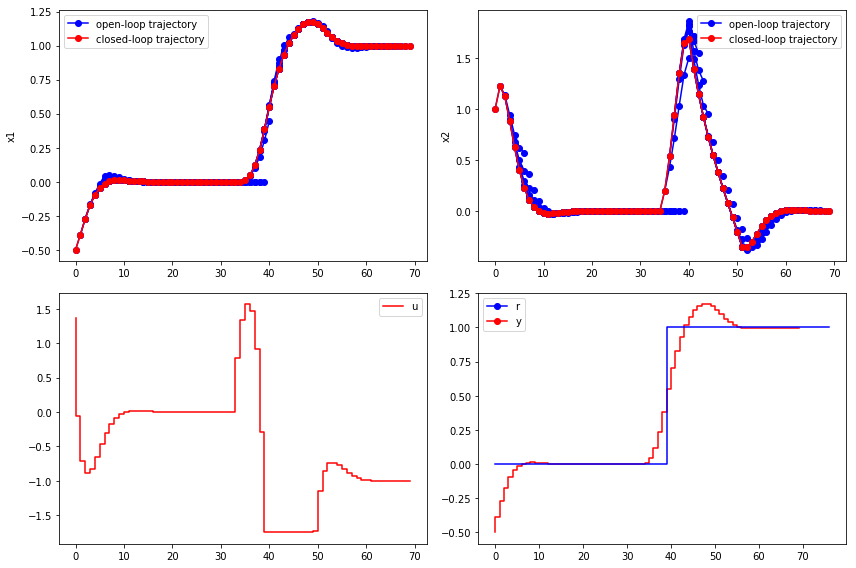

In [10]:
# %matplotlib widget

tuning_param = np.array([0,1]) # The tuning parameter for linear penalty term for the slack variable 

nx = np.size(A, 0)  # number of states
nu = np.size(B, 1)  # number of inputs
ny = np.size(C, 0)  # number of outputs

x0 = np.array([-0.5, 1])
ref = []

# Construct reference signal
for k in range(Lsim+N+1):
    if k < 40: 
        ref.append(0)
    else:
        ref.append(1)

# Initialize  Control Design

umpc_closedloop = []
ym = []
epsU_open1 = []
epsU_open2 = []
xk_open = np.zeros((nx, N+1))    # to plot open-loop trajectories
xk_closed = np.zeros((nx, Lsim+1)) # to plot closed-loop trajectories
xk_closed[:, 0] = x0      # set initial value of closed-loop trajectory
xk = x0.reshape(2,1)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
# simulate MPC controller
for t in range(Lsim):

# Target Algorithm   
    # construct reference preview
    ref_preview = [ref[j] for j in range(t, t+N+1)]
    # compute xref and uref based on futture reference
    xrefk = np.zeros((nx,N+1))
    urefk = np.zeros((nu,N))
    for k in range(N+1):
        Geq = np.vstack( ( np.hstack( (A-np.eye(nx), B) ), np.hstack( (C , np.zeros((ny,nu))) ) ) )
        beq = np.concatenate([np.zeros((nx,1)), np.asarray(ref_preview[k]).reshape(1,1)], axis = 0)   

        # If Geq invertible
        out = (np.linalg.inv(Geq) @ beq).flatten()
        xrefk[:, k] = out[0:nx]
        if k is not N:
            urefk[:, k] = out[nx:nx+nu]

    # Solve MPC 
    [model, feas, xOpt, epsU_Opt, uOpt, JOpt] = solve_cftoc_with_slack(A, B, P, Q, R, N, xk.reshape(2,), x1U, x2U, uL, uU, xrefk, urefk, tuning_param)
    if feas == False:
        print('The problem is infeasible')
    U = uOpt[0,0]
    umpc_closedloop.append(U)
                                    
    if (t < (Lsim-N)):
        epsU_open1.append(epsU_Opt[0, 0])
        epsU_open2.append(epsU_Opt[1, 0])
    # plot open-loop trajectories
        xk_open[:, 0] = xk.reshape(2,)

        for m in range(N):
            xk_open[:, m+1] = A @ xk_open[:, m] + B @ uOpt[:, m]

        line1 = ax1.plot(range(t, t+len(ref_preview) ), xk_open[0,:], 'o-', color='b')
        line2 = ax2.plot(range(t, t+len(ref_preview) ), xk_open[1,:], 'o-', color='b')

    # Plant model update
    ym.append(C @ xk)
    xk = A @ xk + B @ np.asarray(U).reshape(1,1)
    xk_closed[:, t+1] = xk.reshape(2,)
        
##################################################################################################################
##################################################################################################################
# plot closed-loop trajectories
line11 = ax1.plot(range(Lsim), xk_closed[0, :Lsim], 'o-', color='r')
ax1.legend([line1[0], line11[0]], ['open-loop trajectory', 'closed-loop trajectory'])
ax1.set_ylabel('x1')
line22 = ax2.plot(range(Lsim), xk_closed[1, :Lsim], 'o-', color='r')
ax2.legend([line2[0], line22[0]], ['open-loop trajectory', 'closed-loop trajectory'])
ax2.set_ylabel('x2')
# plt.show()

# Plot Results
ax12 = fig.add_subplot(223)
ax22 = fig.add_subplot(224)
ax12.step(range(len(umpc_closedloop)), umpc_closedloop,'r')
ax12.legend(['u'])
ax22.step(range(len(ym)), np.asarray(ym).reshape(Lsim,), 'r')
ax22.step(range(len(ref)), ref, 'b--')
ax22.legend([line2[0], line22[0]], ['r', 'y'])
plt.tight_layout()
plt.show()

# print('x1=', xrefk[0,:])
# print('x2=', xrefk[1,:])
# print('u=', urefk)


64


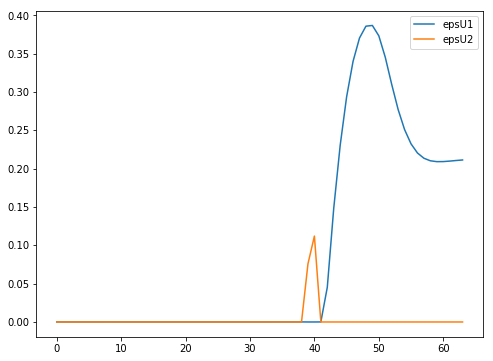

In [11]:
fig = plt.figure(figsize=(8, 6))
print(len(epsU_open1))
plt.plot(range(len(epsU_open1)), epsU_open1) # slack variable
plt.plot(range(len(epsU_open2)), epsU_open2) #slack variable
plt.legend(['epsU1', 'epsU2'])
plt.show()